In [1]:
# Import relevant modules
import os
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras.layers as layers
from keras import callbacks
import keras
import uproot
from Sum import Sum
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
import pandas as pd
import hffrag
import keras_tuner as kt
from hffrag import fixedbinning
from hffrag import binneddensity


2022-11-18 04:58:17.282683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 04:58:17.432945: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-18 04:58:17.438685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-18 04:58:17.438699: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo


PDG ID: 531
number of b-hadrons: 13487

PDG ID: -521
number of b-hadrons: 61531

PDG ID: -511
number of b-hadrons: 61243

PDG ID: 5232
number of b-hadrons: 751

PDG ID: 511
number of b-hadrons: 61706

PDG ID: 521
number of b-hadrons: 61594

PDG ID: -531
number of b-hadrons: 13526

PDG ID: -5122
number of b-hadrons: 5447

PDG ID: 5122
number of b-hadrons: 5232

PDG ID: -5132
number of b-hadrons: 676

PDG ID: 5132
number of b-hadrons: 722

PDG ID: -5232
number of b-hadrons: 733

PDG ID: 555
number of b-hadrons: 3

PDG ID: 553
number of b-hadrons: 6

PDG ID: -5332
number of b-hadrons: 21

PDG ID: 5332
number of b-hadrons: 18

PDG ID: 100553
number of b-hadrons: 1

PDG ID: -541
number of b-hadrons: 5

PDG ID: 10551
number of b-hadrons: 3

PDG ID: 541
number of b-hadrons: 5

PDG ID: 20553
number of b-hadrons: 1



In [2]:
%matplotlib inline


In [3]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("hffrag.root:CharmAnalysis")


In [4]:
# Initial parameter
MASKVAL = -999
MAXTRACKS = 8
BATCHSIZE = 256
EPOCHS = 1000
MAXEVENTS = 1e20
LR = 1e-4


In [5]:
# Connect the tracks of a jet to the jet.
def Match_Tracks(jets, tracks):
    """Used to determine if a set of tracks belong to a particular set of jets"""

    jet_eta = jets["AnalysisAntiKt4TruthJets_eta"]
    jet_phi = jets["AnalysisAntiKt4TruthJets_phi"]

    tracks_eta = tracks["AnalysisTracks_eta"]
    tracks_phi = tracks["AnalysisTracks_phi"]

    delta_etas = jet_eta - tracks_eta
    delta_phis = np.abs(jet_phi - tracks_phi)

    # Map the phis from a cyclical period onto a linear relation
    ak.where(delta_phis > np.pi, delta_phis - np.pi, delta_phis)

    # Returns a list of true and false, determining which tracks belong to those jets.
    return np.sqrt(delta_phis**2 + delta_etas**2) < 0.4


In [6]:
# Convert from cylindrical to cartesian coordinates
def pt_eta_phi_2_px_py_pz_jets(pt_eta_phi):
    """Converts the cylindrical polar coordinates to cartesian coordinates for jets"""

    # Seperate the pts, etas and phis
    pts = pt_eta_phi[:, 0:1]
    etas = pt_eta_phi[:, 1:2]
    phis = pt_eta_phi[:, 2:3]

    # Convert from polar to cartesian
    pxs = pts * np.cos(phis)
    pys = pts * np.sin(phis)
    pzs = pts * np.sinh(etas)

    # Check to see if there are any infinities
    isinf = np.isinf(pzs)

    if np.any(isinf):
        print("Infinities in eta detected!")
        print(etas[isinf])
        raise ValueError("Infinity from sinh(eta) has been detected")

    # Returns the momentum vector
    return np.concatenate([pxs, pys, pzs], axis=1)


In [7]:
def pt_eta_phi_2_px_py_pz_tracks(pt_eta_phi, MASKVAL=-999):
    """Converts the cylindrical polar coordinates to cartesian coordinates for jets"""

    # Seperate the pts, etas and phis
    pts = pt_eta_phi[:, :, 0:1]
    etas = pt_eta_phi[:, :, 1:2]
    phis = pt_eta_phi[:, :, 2:3]

    # Convert from polar to cartesian
    # Removes the tracks where the pts are equal to the mask values
    mask1 = pts == MASKVAL
    mask2 = phis == MASKVAL
    mask3 = etas == MASKVAL
    pxs = np.where(mask1 | mask2, pts, pts * np.cos(phis))
    pys = np.where(mask1 | mask2, pts, pts * np.sin(phis))
    pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))

    # Check to see if there are any infinities
    isinf = np.isinf(pzs)

    if np.any(isinf):
        print("Infinities in eta detected!")
        print(etas[isinf])
        raise ValueError("Infinity from sinh(eta) has been detected")

    # Returns the momentum vector
    return np.concatenate([pxs, pys, pzs], axis=2)


In [8]:
def pad(x_values, maxsize, MASKVAL=-999):
    """
    Pads the inputs with nans to get to the maxsize
    """
    y_values = ak.fill_none(ak.pad_none(
        x_values, maxsize, axis=1, clip=True), MASKVAL)[:, :maxsize]
    return ak.to_regular(y_values, axis=1)


In [9]:
def flatten(x_values, maxsize=-1, MASKVAL=-999):
    """"Pads the input to ensure they are all of regular size and then zips together result"""
    y_values = {}
    for field in x_values.fields:
        z_values = x_values[field]
        if maxsize > 0:
            z_values = pad(z_values, maxsize, MASKVAL)
        y_values[field] = z_values

    return ak.zip(y_values)


In [10]:
def LogNormal_Loss_Function(true, meanscovs_matrix):
    """
    This is a loss function hand crafted for the task of ensuring the neural network 
    learns to predict the true value of the transverse momentum and it's uncertainty
    """
    n_targets = np.shape(true)[1]
    # Obtain data from convarience matrix
    means = meanscovs_matrix[:, :n_targets]
    # ensure diagonal is postive
    logsigma = meanscovs_matrix[:, n_targets:2*n_targets]

    loss = 0
    for n_target in range(n_targets):
        loss += ((means[:, n_target] - true[:, n_target])**2) / (2 * keras.backend.exp(logsigma[:, n_target])**2) + logsigma[:, n_target]

    # Build loss function
    return loss

In [11]:
def LogNormal_Loss_Function_Check(true,meanscovs_matrix):

    n_targets = np.shape(true)[0]
    # Obtain data from convarience matrix
    means = meanscovs_matrix[0, :n_targets]
    # ensure diagonal is postive:
    logsigma = meanscovs_matrix[0, n_targets:2*n_targets]

    loss = 0
    for n_target in range(n_targets):
        loss += ((means[n_target] - true[n_target])**2) / (2 * keras.backend.exp(logsigma[n_target])**2) + logsigma[n_target]

    return loss

In [12]:
def DeepSetNeuralNetwork(track_layers, jet_layers, n_targets,Learning_rate, MASKVAL=-999):
    """
    This function lays out the Deep Set Neural Architecture
    - A neural network is applied first to the tracks to extract information from the tracks.
    - This information produces an ensemble space which, the outputs of which are then summed to produce
        the inputs for the next layer
    - A neural network is then applied to the jet data obtained from the tracks. 
        To perform current univariate regression.
    """
    drop_rate = 0.5
    inputs = layers.Input(shape=(None, track_layers[0]))
    outputs = inputs
    outputs = layers.Masking(mask_value=MASKVAL)(outputs)

    for nodes in track_layers[:-1]:
        outputs = layers.TimeDistributed(
            layers.Dense(nodes, activation="relu", kernel_initializer= "he_normal"))(outputs)
        outputs = layers.Dropout(0.05)(outputs)
        outputs = layers.BatchNormalization()(outputs)

    outputs = layers.TimeDistributed(layers.Dense(
        track_layers[-1], activation='softmax'))(outputs)
    outputs = Sum()(outputs)

    for nodes in jet_layers:
        outputs = layers.Dense(nodes, activation='relu', kernel_initializer= "he_normal")(outputs)
        outputs = layers.Dropout(0.05)(outputs)
        outputs = layers.BatchNormalization()(outputs)

    outputs = layers.Dense(2*n_targets)(outputs)

    Model = keras.Model(inputs=inputs, outputs=outputs)

    # Specify the neural network's optimizer and loss function
    Model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=Learning_rate,clipnorm = 1.0),
    loss=LogNormal_Loss_Function
    )

    return Model


In [13]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi"]


In [14]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features, entry_stop=MAXEVENTS)

In [15]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]


In [16]:
# Displays the number of jets being trained on
jets = events[jet_features][:, 0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  141329
The number of track features is:  8


In [17]:
# Select tracks from the events
tracks = events[track_features]

# Match the tracks to the jets
matchedtracks = tracks[Match_Tracks(jets, tracks)]

# Pad and Flatten the data
matchedtracks = flatten(matchedtracks, MAXTRACKS)

In [18]:
# Identify the the bottom jets and their associated tracks
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads = np.stack([bhads_pt,bhads_eta,bhads_phi],axis = -1)

print("There are {} outputs".format(np.shape(bhads)[1]))
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1]))

There are 3 outputs
There are 8 inputs


In [19]:
print(np.shape(bhads))
print(np.shape(jet_features[:-1]))
print(jets[jet_features[0]])

(68143, 3)
(5,)
[1.48e+05, 1.04e+05, 1.16e+05, 4.03e+04, ... 8.14e+04, 9.83e+04, 1.45e+05, 9.11e+04]


In [20]:
# Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-3]])
matchedtracks = structured_to_unstructured(matchedtracks)
print(np.shape(jets))

(68143, 3)


In [21]:
print(matchedtracks[:, 0:1])
print(np.shape(matchedtracks[:, :, 3]))

[[[1.47e+04, 0.753, 1.14, 1.19, 75.5, ... -0.165, -0.51, -0.0283, -0.692, -0.038]]]
(68143, 8)


In [22]:
# Fix the angles
jets = pt_eta_phi_2_px_py_pz_jets(jets).to_numpy()
tracks_p = pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = pt_eta_phi_2_px_py_pz_jets(bhads)
print(np.shape(tracks_p))
print(np.shape(matchedtracks[:, :, 3:]))
tracks = np.concatenate([tracks_p,matchedtracks[:,:,3:].to_numpy()],axis = 2)

(68143, 8, 3)
(68143, 8, 5)


/tmp/ipykernel_11022/289123523.py:16: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [23]:
print(np.shape(tracks))
print(tracks[0,0])
print(bhads[0])


(68143, 8, 8)
[6.20926450e+03 1.33553447e+04 1.21693980e+04 1.18753994e+00
 7.55359192e+01 1.33110714e+00 8.57456207e+01 1.32391548e+00]
[ 48855.56531144 128363.19160447 124938.01790683]


In [24]:
# Builds the deep neural network
track_layers = [192, 192, 192, 192, 192]
jet_layers = [192, 192, 192, 192, 192]
DeepNet = DeepSetNeuralNetwork(
    [len(track_features)]+track_layers, jet_layers,3, LR)


2022-11-18 05:00:04.744238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-18 05:00:04.744267: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-18 05:00:04.744282: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2022-11-18 05:00:04.744462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
def model_builder(hp):
    """
    This function lays out the Deep Set Neural Architecture
    - A neural network is applied first to the tracks to extract information from the tracks.
    - This information produces an ensemble space which, the outputs of which are then summed to produce
        the inputs for the next layer
    - A neural network is then applied to the jet data obtained from the tracks. 
        To perform current univariate regression.
    """
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    track_layers = [len(track_features)] + [hp_units,
                                            hp_units, hp_units, hp_units, hp_units]
    jet_layers = [hp_units, hp_units, hp_units, hp_units, hp_units]
    n_targets = 3
    drop_rate = 0.5
    inputs = layers.Input(shape=(None, track_layers[0]))
    outputs = inputs
    outputs = layers.Masking(mask_value=MASKVAL)(outputs)

    for nodes in track_layers[:-1]:
        outputs = layers.TimeDistributed(
            layers.Dense(nodes, activation="elu", kernel_initializer= "he_normal"))(outputs)
        outputs = layers.BatchNormalization()(outputs)

    outputs = layers.TimeDistributed(layers.Dense(
        track_layers[-1], activation='softmax'))(outputs)
    outputs = Sum()(outputs)

    for nodes in jet_layers:
        outputs = layers.Dense(nodes, activation="elu", kernel_initializer= "he_normal")(outputs)
        outputs = layers.BatchNormalization()(outputs)

    outputs = layers.Dense(n_targets + n_targets*(n_targets+1)//2)(outputs)

    # Tune the learning rate of the optimizer
    hp_learning_rate = hp.Choice("learning_rate", values=[
                                 1e-1, 1e-2, 1e-3, 1e-4, ])

    Model = keras.Model(inputs=inputs, outputs=outputs)
    Model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=LogNormal_Loss_Function, metrics=[LogNormal_Loss_Function])

    return Model


In [26]:
DeepNet.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 8)]         0         
                                                                 
 masking (Masking)           (None, None, 8)           0         
                                                                 
 time_distributed (TimeDistr  (None, None, 8)          72        
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, None, 8)           0         
                                                                 
 batch_normalization (BatchN  (None, None, 8)          32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, None, 192)        1728  

In [27]:
# Split the data into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(
    tracks, bhads, train_size=0.7, random_state=42)


In [28]:
print(np.shape(X_train), np.shape(y_train))


(47700, 8, 8) (47700, 3)


In [43]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,  # The minimum amount of change to count as an improvement
    patience=20,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.8, patience=10, min_lr=1e-6)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPoints/DeepNetWeights&Biases-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_best_only=True)


In [30]:
# Train the neural network
history = DeepNet.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCHSIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_learn_on_plateau,
               cp_callback]  # Enter call back
)


Epoch 1/1000
187/187 [==============================] - 7s 23ms/step - loss: 2030715273216.0000 - val_loss: 67994734592.0000 - lr: 1.0000e-04
Epoch 2/1000
187/187 [==============================] - 4s 20ms/step - loss: 25394851840.0000 - val_loss: 30074701824.0000 - lr: 1.0000e-04
Epoch 3/1000
187/187 [==============================] - 4s 20ms/step - loss: 9706817536.0000 - val_loss: 6567086080.0000 - lr: 1.0000e-04
Epoch 4/1000
187/187 [==============================] - 4s 20ms/step - loss: 4823389696.0000 - val_loss: 2732318208.0000 - lr: 1.0000e-04
Epoch 5/1000
187/187 [==============================] - 4s 21ms/step - loss: 2460637184.0000 - val_loss: 1906685056.0000 - lr: 1.0000e-04
Epoch 6/1000
187/187 [==============================] - 4s 20ms/step - loss: 1221481088.0000 - val_loss: 839875776.0000 - lr: 1.0000e-04
Epoch 7/1000
187/187 [==============================] - 4s 20ms/step - loss: 562345984.0000 - val_loss: 300955200.0000 - lr: 1.0000e-04
Epoch 8/1000
187/187 [=========

<AxesSubplot:>

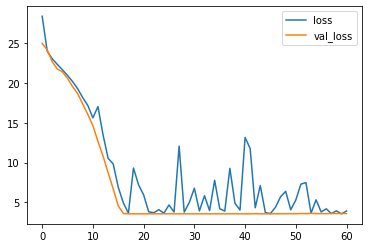

In [31]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
np.log(history_df.loc[:, ["loss", "val_loss"]]).plot()


In [32]:
# Have the model predict the total momentum of the b tracks
predictions = DeepNet.predict(tracks)
# Output the first 10 guesses
print(predictions[:10])


2130/2130 [==============================] - 4s 2ms/step
[[  3.5618067   -5.0864577   -0.62015516  10.752908    10.524082
   11.603152  ]
 [  4.3047967   -3.9066625   -0.5520572   11.071079    10.455435
   11.773886  ]
 [ -1.6263082  -10.639834    -8.087603    10.55743     10.992943
   12.366784  ]
 [ -0.99395466 -11.048855    -7.1698036   10.505982    11.117477
   12.1648245 ]
 [  0.03132836 -10.37358     -6.029527    10.372187    11.139601
   12.077116  ]
 [  2.6072235   -5.504687    -2.4190638   10.733937    10.866156
   11.6250305 ]
 [  5.1170454   -3.0718591    1.8761926   10.966973    10.485588
   11.873177  ]
 [ -0.48685053 -10.077505    -6.53706     10.459536    11.057657
   12.094972  ]
 [  0.18489096 -10.586338    -6.2642574   10.690289    10.94231
   12.209788  ]
 [  3.6513016   -3.3267725   -0.7500735   11.028736    10.927835
   11.628569  ]]


In [33]:
# Output to the console the minimum epoch
print("Minimum validation loss: {}".format(history_df["val_loss"].min()))

Minimum validation loss: 35.78717803955078


In [34]:
# Ensure the dimensions are correct
print(len(tracks), len(predictions))
print(np.shape(predictions))

68143 68143
(68143, 6)


In [35]:
# Create the distribution of errors to access the performance of the neural network
pull = (predictions[:, 1] - bhads[:,1])
scaled_pull = pull/np.exp(predictions[:, 4])
# Compare and constrast the true and predicted momentums
print(np.min(predictions[:,1]),np.max(predictions[:,1]))

print("Minimum and maximum values")
print("The min/max of bhad momenta: ", np.min(bhads), np.max(bhads))
print("The min/max of the ppred - ptrue", np.min(pull), np.max(pull))
print("The min/max of the pull", np.min(scaled_pull), np.max(scaled_pull))

print("Median and IQR")
print("The Median/IQR for the ppred - ptrue: ", np.median(pull),
      np.percentile(pull, 75)-np.percentile(pull, 25))
print("The Median/IQR for the pull ", np.median(scaled_pull),
      np.percentile(scaled_pull, 75)-np.percentile(scaled_pull, 25))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(pull), np.std(pull))
print("The mean/std for the pull", np.mean(scaled_pull), np.std(scaled_pull))


-14.90728 120.451904
Minimum and maximum values
The min/max of bhad momenta:  -2273167.0883596055 1827356.5267840482
The min/max of the ppred - ptrue -777837.9499493665 467827.9026205825
The min/max of the pull -12.74473821572968 8.535503734195974
Median and IQR
The Median/IQR for the ppred - ptrue:  394.32195937929214 91235.52927310788
The Median/IQR for the pull  0.008586751759153686 1.778325933350898
Mean and standard deviation
The mean/std for the ppred - ptrue:  62.89892767744419 65421.146704035906
The mean/std for the pull -0.10842962354235346 1.2751875922094418


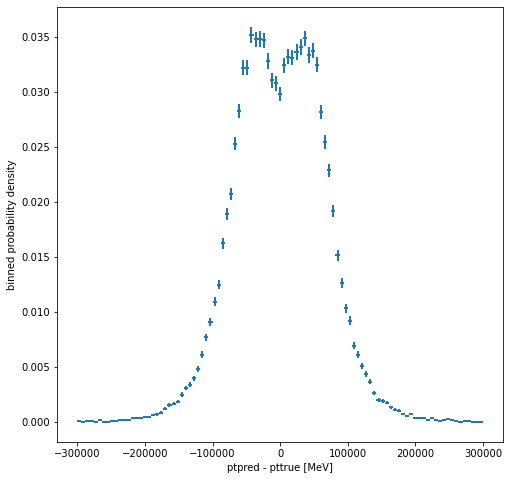

In [36]:
fig = binneddensity(pull, fixedbinning(-3e5, 3e5, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig


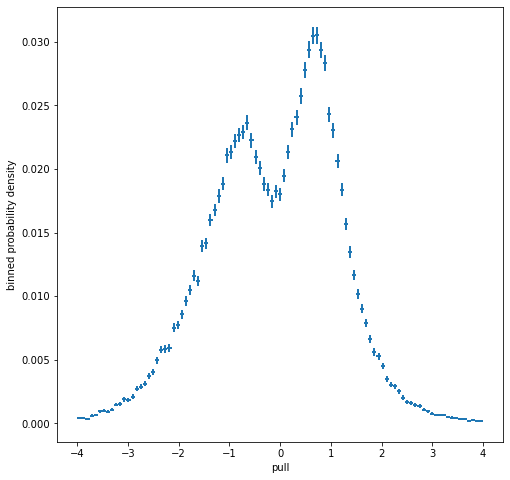

In [37]:
fig = binneddensity(scaled_pull, fixedbinning(-4.0, 4.0, 100), xlabel="pull")
fig


In [38]:
print(DeepNet.predict(tracks[1]))
print(bhads[1])

LogNormal_Loss_Function_Check(bhads[1],DeepNet.predict(tracks[1]))

1/1 [==============================] - 0s 304ms/step
[[ 4.3047967 -3.9066625 -0.5520572 11.071079  10.455435  11.773886 ]]
[   843.45625286  77133.74792279 179693.16123271]
1/1 [==============================] - 0s 20ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=36.724686>

In [39]:
loss = DeepNet.evaluate(tracks,bhads,verbose = 2)
print("The Loaded DeepNet has loss: ", round(loss,3))

2130/2130 - 3s - loss: 35.7953 - 3s/epoch - 2ms/step
The Loaded DeepNet has loss:  35.795


In [40]:
SEED = tf.random.set_seed(42)
max_trials = 10
tuner = kt.RandomSearch(model_builder,
                        objective='val_loss',
                        seed=SEED,
                        overwrite=True,
                        max_trials=5,
                        directory='/home/physics/phujdj/DeepLearningParticlePhysics',
                        project_name="DeepSetHyperTraining",
                        )


In [41]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [42]:
tuner.search(X_train, y_train, validation_data=(
    X_valid, y_valid), epochs=20, callbacks=[stop_early])



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
288               |?                 |units
0.001             |?                 |learning_rate

Epoch 1/20
1491/1491 [==============================] - 18s 11ms/step - loss: 10087250944.0000 - LogNormal_Loss_Function: 10087250944.0000 - val_loss: 1398701568.0000 - val_LogNormal_Loss_Function: 1398701568.0000
Epoch 2/20
1491/1491 [==============================] - 15s 10ms/step - loss: 834950784.0000 - LogNormal_Loss_Function: 834950784.0000 - val_loss: 396306080.0000 - val_LogNormal_Loss_Function: 396306080.0000
Epoch 3/20
1491/1491 [==============================] - 15s 10ms/step - loss: 265453520.0000 - LogNormal_Loss_Function: 265453520.0000 - val_loss: 142133040.0000 - val_LogNormal_Loss_Function: 142133040.0000
Epoch 4/20
1491/1491 [==============================] - 15s 10ms/step - loss: 96984792.0000 - LogNormal_Loss_Function: 96984792.0000 - val_loss: 64365052.0000 - val_LogNormal_Loss_Function: 643

KeyboardInterrupt: 

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=10)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")
